In [2]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time
import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
Tank_data = pd.read_csv('project_data.csv')
Tank_data = Tank_data.drop(['Unnamed: 0'], axis=1)

In [4]:
Tank_data.head()

Pressure  Tank_Thickness  temperature  Large_outer_diameter_Deformation  \
0       168           5.000           22                          0.232511   
1       165           4.631           28                          0.249610   
2       162           5.111           26                          0.221167   
3       160           5.200           32                          0.217626   
4       158           5.118           25                          0.214917   

   Small_outer_diameter_Deformation  Total_length_Deformation  
0                          0.088142                  1.071509  
1                          0.095379                  1.198593  
2                          0.084324                  1.051053  
3                          0.083697                  1.082452  
4                          0.081842                  1.014332

In [5]:
Tank_data = Tank_data.astype(np.float64)
X = Tank_data[['Pressure', 'Tank_Thickness', 'temperature', 'Large_outer_diameter_Deformation', 'Small_outer_diameter_Deformation']]
Y = Tank_data[['Total_length_Deformation']]
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
Y = Y.to_numpy()
X_train,X_test,Y_train,Y_test = train_test_split(X,Y)

In [6]:
X_train.shape

(225, 5)

In [7]:
X_test.shape

(76, 5)

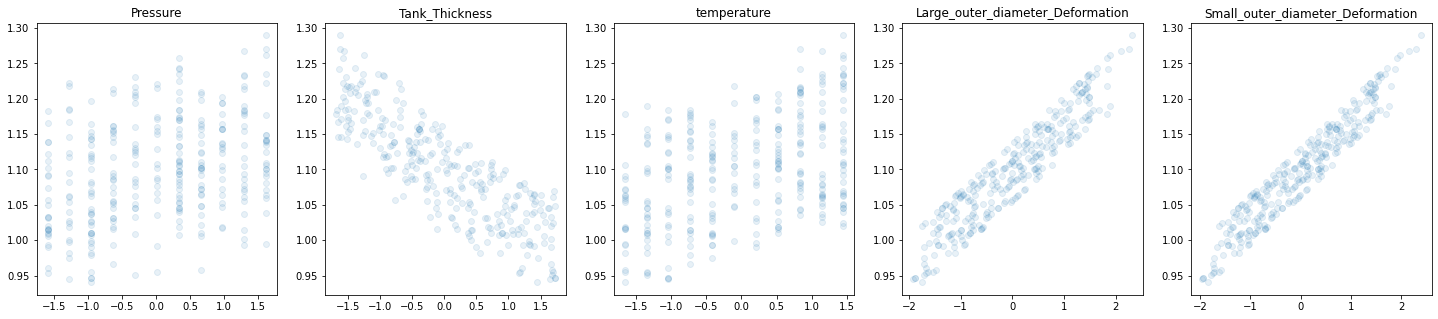

In [5]:
plt.figure(figsize=[25,5])
for col in range(5):
    plt.subplot(1,5,col+1)
    plt.scatter(X[:,col], Y, alpha=0.1)
    plt.title(Tank_data.columns[col])

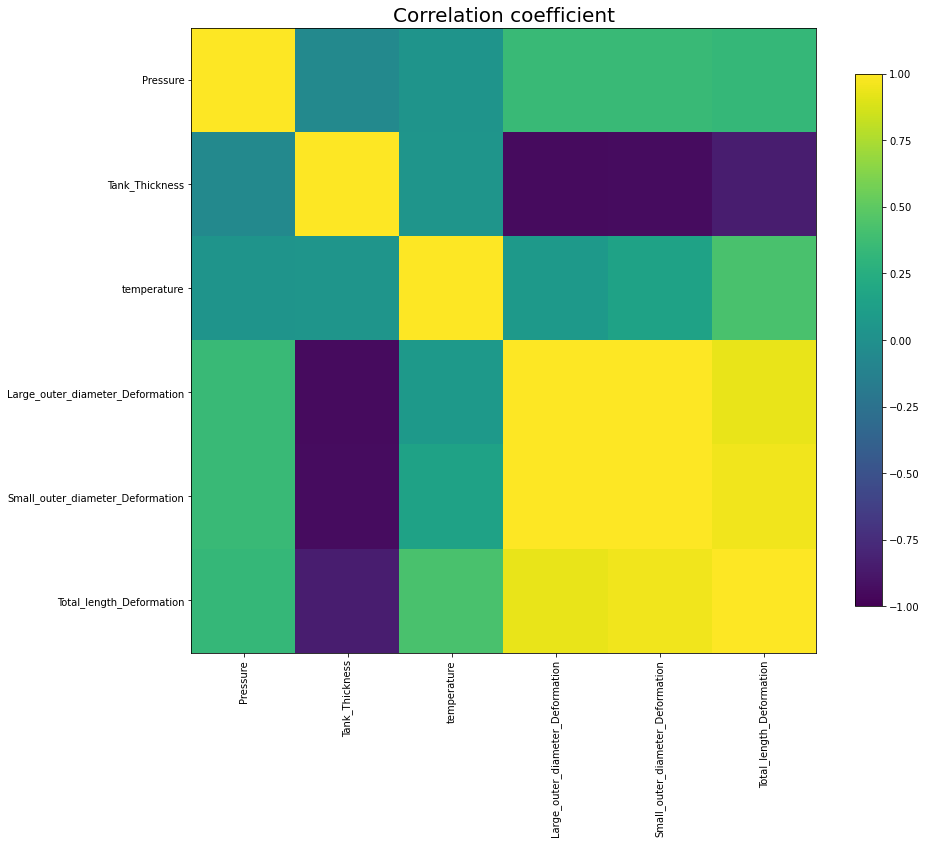

In [6]:
XY = np.concatenate((X,Y), axis = 1)
matt = np.corrcoef(XY.T)
Tank_title = np.array(['Pressure', 'Tank_Thickness', 'temperature','Large_outer_diameter_Deformation', 'Small_outer_diameter_Deformation','Total_length_Deformation'])
fig = plt.figure(figsize = [14,14])
plt.title('Correlation coefficient', fontsize = 20)
plt.imshow(matt, interpolation = 'none', vmin = -1, vmax = 1)
plt.colorbar(shrink = 0.7)
plt.xticks(range(6), Tank_title, rotation = 90, ha = 'center')
plt.yticks(range(6), Tank_title, rotation = 0)
print('')

In [7]:
n_num = 30
acti = F.relu
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(5, n_num).double()
        self.fc2 = nn.Linear(n_num, n_num).double()
        self.fc3 = nn.Linear(n_num, n_num).double()
        self.fc4 = nn.Linear(n_num, n_num).double()
        self.fc5 = nn.Linear(n_num, n_num).double()
        self.fc6 = nn.Linear(n_num, n_num).double()
        self.fc7 = nn.Linear(n_num, n_num).double()
        self.fc8 = nn.Linear(n_num, n_num).double()
        self.fc9 = nn.Linear(n_num, 1).double()
        
    def forward(self, x):
        x = acti(self.fc1(x))
        x = acti(self.fc2(x))
        x = acti(self.fc3(x))
        x = acti(self.fc4(x))
        x = acti(self.fc5(x))
        x = acti(self.fc6(x))
        x = acti(self.fc7(x))
        x = acti(self.fc8(x))
        x = (self.fc9(x))
        return x
    
model = Net()

In [8]:
tic = time.perf_counter()
train_size = Y_train.shape[0]
area = list(range(train_size))
criterion = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.000001)
for epoch in range(1000):
    batch_size = 50
    rand_area = random.sample(area,train_size)
    for batch_step in range(train_size//batch_size):
        loss = 0
        t = []
        qh = []
        batch_index = np.asarray(rand_area[batch_size*batch_step:batch_size*(batch_step+1)])
        t.append(X_train[batch_index,:])
        qh.append(Y_train[batch_index])
        t = np.array(t, dtype = 'float64')
        qh = np.array(qh, dtype = 'float64')
        t = Variable(torch.from_numpy(t))
        qh = Variable(torch.from_numpy(qh))
        optimizer.zero_grad()
        output = model(t)
        loss = criterion(output, qh)
        loss.backward()
        optimizer.step()
    if (epoch+1) % 100 == 0:
        print(epoch+1, loss)
    if loss < 1e-6:
        print(epoch+1, loss)
        break
        
toc = time.perf_counter()
print(f"Working time is {toc - tic:0.4f} seconds")

100 tensor(9.3613e-06, dtype=torch.float64, grad_fn=<MseLossBackward>)
200 tensor(3.1452e-06, dtype=torch.float64, grad_fn=<MseLossBackward>)
300 tensor(1.7134e-06, dtype=torch.float64, grad_fn=<MseLossBackward>)
366 tensor(8.4742e-07, dtype=torch.float64, grad_fn=<MseLossBackward>)
Working time is 2.6010 seconds


In [9]:
tt_tensor = np.array(X_train, dtype='float64')
tt_tensor = Variable(torch.from_numpy(tt_tensor))
result = []
view_area = train_size
for i in range(view_area):
    tin = tt_tensor[i,:]
    tout = model(tin)
    tout = tout.detach().numpy()
    result.append(tout)
result = np.array(result)

[1.63861233e-06]


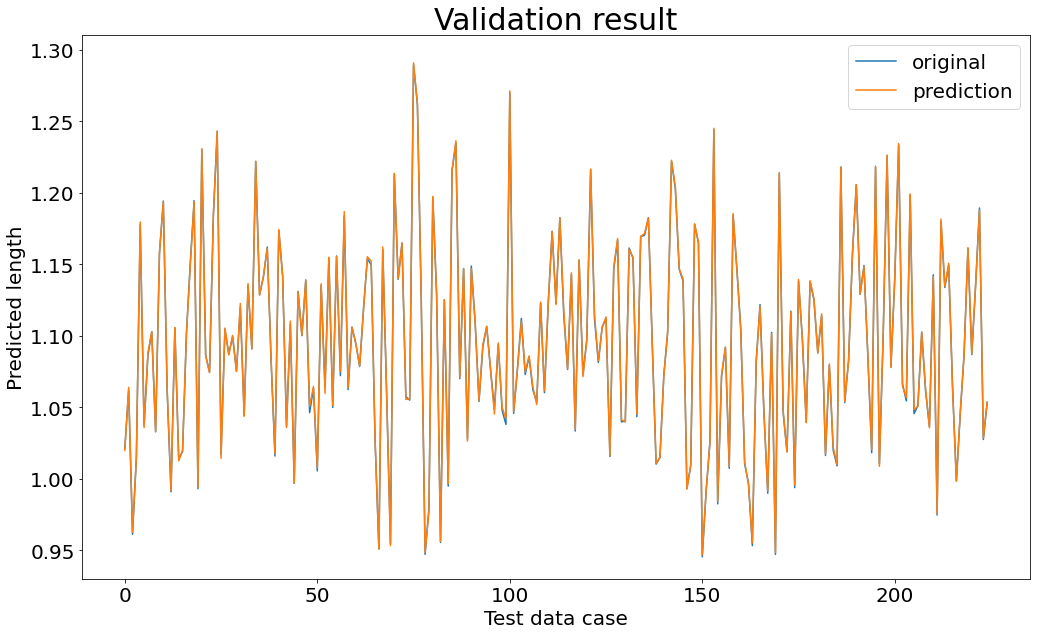

In [24]:
print((np.square(result - Y_train)).mean(axis = 0))
plt.figure(figsize = [17,10])
plt.rcParams.update({'font.size': 20})
plt.plot(Y_train, label = 'original')
plt.plot(result, label = 'prediction')
plt.xlabel("Test data case")
plt.ylabel("Predicted length")
plt.title('Validation result', fontsize = 30)
plt.ylim(0.93,1.31)
plt.legend(loc = 'upper right')
plt.show()

In [11]:
X_input = np.array(X_test, dtype = 'float64')
X_input = Variable(torch.from_numpy(X_input))
pre = model(X_input)
pre = pre.detach().numpy()

[3.43871124e-06]


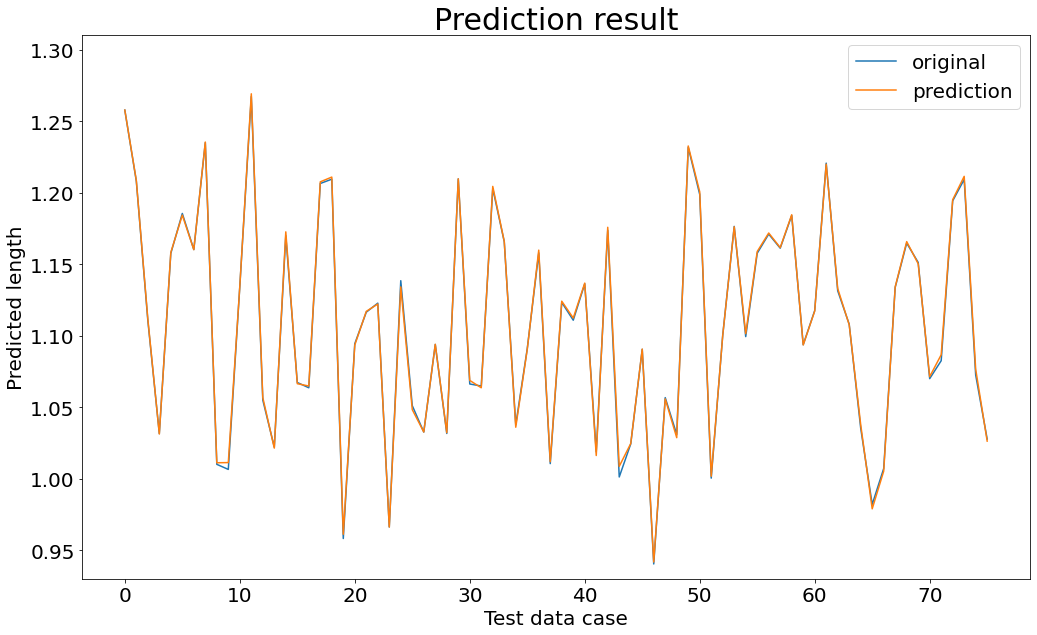

In [25]:
print((np.square(pre - Y_test)).mean(axis = 0))
plt.figure(figsize = [17,10])
plt.plot(Y_test, label = 'original')
plt.plot(pre, label = 'prediction')
plt.legend(loc = 'upper right')
plt.xlabel("Test data case")
plt.ylabel("Predicted length")
plt.title('Prediction result', fontsize = 30)
plt.ylim(0.93,1.31)
plt.show()